# Annual Cycles (range)

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tqdm import tqdm

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [2]:
def datasets_preparation(dict_month, i, mask, mesh):

    ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i[1] + '/SalishSea_1d_' + '20' + str(i[1][5:7]) + str(dict_month[i[1][2:5]])+str(i[1][0:2]) + '_' + '20' + str(i[1][5:7]) + str(dict_month[i[1][2:5]]) + str(i[1][0:2]) + '_grid_T.nc')
    ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i[1] + '/SalishSea_1d_'  + '20' + str(i[1][5:7]) + str(dict_month[i[1][2:5]])+str(i[1][0:2]) + '_' + '20' + str(i[1][5:7]) + str(dict_month[i[1][2:5]]) + str(i[1][0:2]) + '_biol_T.nc')
    ds_prod_name = ('/results2/SalishSea/nowcast-green.202111/' + i[1] + '/SalishSea_1d_'  + '20' + str(i[1][5:7]) + str(dict_month[i[1][2:5]])+str(i[1][0:2]) + '_' + '20' + str(i[1][5:7]) + str(dict_month[i[1][2:5]]) + str(i[1][0:2]) + '_prod_T.nc') 

    ds = xr.open_dataset (ds_name)
    ds_bio = xr.open_dataset (ds_bio_name)
    ds_prod = xr.open_dataset (ds_prod_name)

    diat_i = ((ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
        [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27])
    
    flag_i = ((ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
        [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27])
    
    diat_prod_i = ((ds_prod.PPDIAT.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
        [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]) / diat_i  
      
    flag_prod_i = ((ds_prod.PPPHY.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
        [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]) / flag_i


    return (diat_i,flag_i,diat_prod_i,flag_prod_i)


## Datasets Preparation 2

In [3]:
def datasets_preparation2(name, units, coords):

    dataset = xr.DataArray(coords=coords, dims = ['time_counter', 'y', 'x'],
        attrs=dict(description='Integrated quantity of interest',
        long_name =name,
        units=units))
        
    return (dataset)


## Plotting (Regions)

In [4]:
def plot_box(ax, corn, colour):

    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
    [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)
    

## Plotting (Results)


In [5]:
def plotting(name,quant,boxnames,regions0):

    print(name)

    (quant.std(['y','x'])).plot(aspect=2, size=10,  marker = '*')
    plt.show()

    labels = np.unique(quant.time_counter.dt.strftime('%d %b'))
    indx_labels = np.argsort(pd.to_datetime(labels, format='%d %b'))
    labels = labels[indx_labels]

    fig, axs = plt.subplots(figsize=(19,10))

    for i in range (0, len(boxnames)):

        temp = quant.where(regions0==i).mean(['y','x']).groupby(['time_counter.month', 'time_counter.day']).max() - quant.where(regions0==i).mean(['y','x']).groupby(['time_counter.month', 'time_counter.day']).min()
        temp = temp.to_numpy()
        temp = np.ravel(temp)

        axs.plot(labels, temp, label=boxnames[i])
        
    axs.set_xticks(np.arange(0,len(labels),3))

    fig.legend()
    plt.show()


## Data Collection

In [6]:
dict_month = {'jan': '01',
    'feb': '02',
    'mar': '03',
    'apr': '04',
    'may': '05',
    'jun': '06',
    'jul': '07',
    'aug': '08',
    'sep': '09',
    'oct': '10',
    'nov': '11',
    'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

folders = [x for x in path if ((x[0:2] == '01') or (x[0:2] == '15')) and (x[5:7]< '25')]

indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

coords = dict(time_counter=pd.to_datetime(folders, format="%d%b%y"), y=mesh.y, x=mesh.x) 

diat_i_all = datasets_preparation2('Diatom Concentration', '[mmol m-2]', coords)
flag_i_all = datasets_preparation2('Flagellate Concentration', '[mmol m-2]', coords)

diat_prod_i_all = datasets_preparation2('Diatom Production Rate', '[mmol N m-2 s-1]', coords)
flag_prod_i_all = datasets_preparation2('Flagellate Production Rate', '[mmol N m-2 s-1]', coords)

print(len(folders))

for i in tqdm(enumerate(folders)):

    diat_i, flag_i, diat_prod_i, flag_prod_i = datasets_preparation(dict_month, i, mask, mesh)

    diat_i_all[i[0]] = diat_i
    flag_i_all[i[0]] = flag_i

    diat_prod_i_all[i[0]] = diat_prod_i
    flag_prod_i_all[i[0]] = flag_prod_i


432


432it [24:12,  3.36s/it]


## Regions

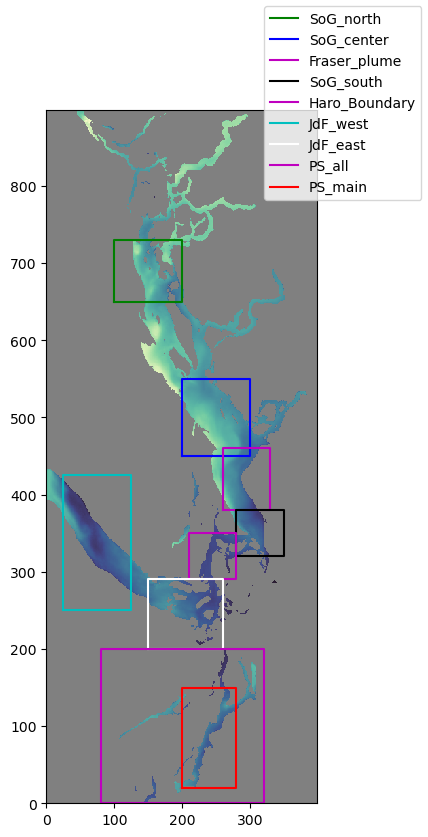

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(flag_i, cmap=mycmap)
sa_vi.set_aspect(ax)

SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'm')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'c')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'w')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'r')

boxnames = ['SoG_north','SoG_center','Fraser_plume','SoG_south', 'Haro_Boundary', 'JdF_west', 'JdF_east', 'PS_all', 'PS_main']
fig.legend(boxnames)

boxes = [SoG_north,SoG_center,Fraser_plume,SoG_south,Haro_Boundary,JdF_west,JdF_east,PS_all,PS_main]

regions0 = np.full((len(flag_i.y),len(flag_i.x)),np.nan)

for i in range (0, len(boxes)):
    regions0[boxes[i][0]:boxes[i][1], boxes[i][2]:boxes[i][3]] = i

regions0 = xr.DataArray(regions0,dims = ['y','x'])


## Results

In [ ]:
plotting('Diatom', diat_i_all, boxnames, regions0)
plotting('Flagellate', flag_i_all, boxnames, regions0)
plotting('Diatom production rate', diat_prod_i_all, boxnames, regions0)
plotting('Flagellate production rate', flag_prod_i_all, boxnames, regions0)


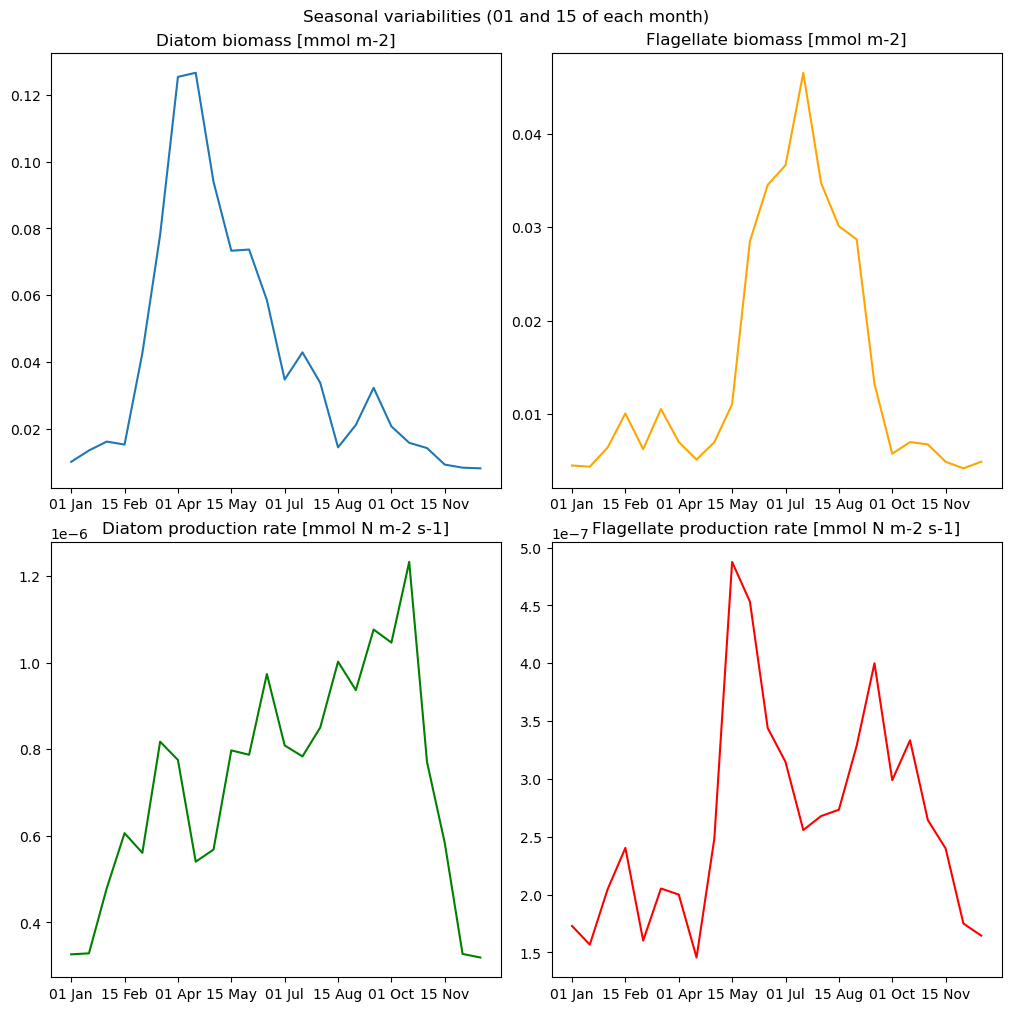

In [28]:
labels = np.unique(diat_i_all.time_counter.dt.strftime('%d %b'))
indx_labels = np.argsort(pd.to_datetime(labels, format='%d %b'))
labels = labels[indx_labels]

fig, axs = plt.subplots(2,2, figsize=(10,10), layout='constrained')

temp = diat_i_all.mean(['y','x']).groupby(['time_counter.month', 'time_counter.day']).std()
temp = temp.to_numpy()
temp = np.ravel(temp)
axs[0,0].plot(labels, temp)
axs[0,0].set_title('Diatom biomass [mmol m-2]')

temp = flag_i_all.mean(['y','x']).groupby(['time_counter.month', 'time_counter.day']).std()
temp = temp.to_numpy()
temp = np.ravel(temp)
axs[0,1].plot(labels, temp, color='orange')
axs[0,1].set_title('Flagellate biomass [mmol m-2]')

temp = diat_prod_i_all.mean(['y','x']).groupby(['time_counter.month', 'time_counter.day']).std()
temp = temp.to_numpy()
temp = np.ravel(temp)
axs[1,0].plot(labels, temp, color='green')
axs[1,0].set_title('Diatom production rate [mmol N m-2 s-1]')

temp = flag_prod_i_all.mean(['y','x']).groupby(['time_counter.month', 'time_counter.day']).std()
temp = temp.to_numpy()
temp = np.ravel(temp)
axs[1,1].plot(labels, temp, color='red')
axs[1,1].set_title('Flagellate production rate [mmol N m-2 s-1]')

fig.suptitle('Seasonal variabilities (01 and 15 of each month)')

axs[0,0].set_xticks(np.arange(0,len(labels),3))
axs[0,1].set_xticks(np.arange(0,len(labels),3))
axs[1,0].set_xticks(np.arange(0,len(labels),3))
axs[1,1].set_xticks(np.arange(0,len(labels),3))

plt.show()